Implementing ResNet

In [31]:
!pip install modlee

python(38252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [41]:
import os,zipfile,shutil,requests

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.jit as jit
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
import lightning.pytorch as pl
import modlee
import math
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

In [43]:
os.environ['MODLEE_API_KEY'] = "LwNrkLZKLqnrkipRBBCyXFomWnFZczMg"
api_key = os.environ['MODLEE_API_KEY']
modlee.init(api_key=api_key)

In [45]:
exercise_id = "L_D_C__333792950926"  
exercise_modality = "image"  
exercise_task = "classification"  
model_size_restriction_MB = 20 

assert exercise_id != "replace-with-your-exercise-id", "Please update the placeholder for your Modlee Exercise ID. See above Installation instructions."
assert exercise_modality != "replace-with-your-modality", "Please update the placeholder for your Modlee Exercise ID. See above Installation instructions."
assert exercise_task != "replace-with-your-exercise-task", "Please update the placeholder for your Modlee Exercise Task. See above Installation instructions."
assert model_size_restriction_MB != "replace-with-your-model_size_restriction_MB", "Please update the placeholder for your Modlee Exercise model_size_restriction_MB. See above Installation instructions."

In [47]:
root_url = 'https://evalserver.modlee.ai:5000'
url = f"{root_url}/get-interview-utils"  # Change the port if your Flask app is running on a different one
response = requests.get(url, params={'api_key': api_key,'exercise_id':exercise_id})

# Check if the request was successful
if response.status_code == 200:
    with open('interview_utils.py', 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print("File downloaded and saved as interview_utils.py")
else:
    print("Failed to download file:", response.status_code)

from interview_utils import *
from interview_utils import ModleeImageClassifier,setup,submit

train_dataloader,val_dataloader,example_batch_images = setup(api_key,exercise_id)

File downloaded and saved as interview_utils.py
File downloaded successfully: ./modlee_interview_data/modlee_interview_data.zip
IMAGE CLASSIFICATION


In [48]:
print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


Input image size (batch size, channels, height, width): torch.Size([32, 3, 32, 32])
Image resolution (height x width): 32 x 32


Total number of unique labels in the dataset: 21
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


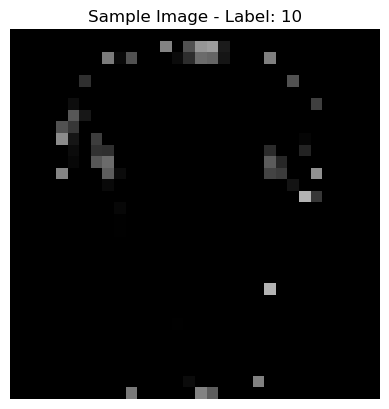

In [49]:
import matplotlib.pyplot as plt

unique_labels = set()  # Initialize a set to collect unique labels
sample_image = None  # Placeholder for a sample image
image_size = None  # Placeholder for image size

# Iterate through the DataLoader
for images, labels in train_dataloader:
    # Add labels to the set
    unique_labels.update(labels.numpy())  # Convert tensor to numpy and add to the set
    
    # Capture the image size and resolution from the first batch
    if image_size is None:
        image_size = images.size()  # Get the size of the image tensor (B, C, H, W)
        print(f"Input image size (batch size, channels, height, width): {image_size}")
        print(f"Image resolution (height x width): {image_size[2]} x {image_size[3]}")
    
    # Store the first image as a sample
    if sample_image is None:
        sample_image = images[0]  # Take the first image from the batch

    break  # Stop after the first batch for demonstration
    
for images, labels in val_dataloader:
    unique_labels.update(labels.numpy()) 
    
    
# Convert the set to a sorted list for better readability
unique_labels_list = sorted(unique_labels)

# Print the total number of unique labels
print(f"Total number of unique labels in the dataset: {len(unique_labels)}")

# Print all unique labels
print("Unique labels:", unique_labels_list)

# Convert the sample image tensor to a NumPy array for visualization
sample_image_np = sample_image.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

# Visualize the sample image
plt.imshow(sample_image_np)  # Display the image
plt.title(f"Sample Image - Label: {labels[0].item()}")  # Set the title to the label
plt.axis('off')  # Turn off axis
plt.show()

In [50]:
# Adjusted parameters for efficientnet_b0 to fit within the size constraint
params = {
    "efficientnet_b0": (1.0, 1.1, 240, 0.2),  # Reduced width and depth multipliers, input size adjusted
}

class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes: int, out_planes: int, kernel_size: int, stride: int = 1, groups: int = 1) -> None:
        padding = self._get_padding(kernel_size, stride)
        super().__init__(
            nn.ZeroPad2d(padding),
            nn.Conv2d(
                in_planes,
                out_planes,
                kernel_size,
                stride,
                padding=0,
                groups=groups,
                bias=False,
            ),
            nn.BatchNorm2d(out_planes),
            Swish(),
        )

    def _get_padding(self, kernel_size, stride):
        p = max(kernel_size - stride, 0)
        return [p // 2, p - p // 2, p // 2, p - p // 2]

class SqueezeExcitation(nn.Module):
    def __init__(self, in_planes: int, reduced_dim: int) -> None:
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_planes, reduced_dim, 1),
            Swish(),
            nn.Conv2d(reduced_dim, in_planes, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.se(x)

class MBConvBlock(nn.Module):
    def __init__(self, in_planes: int, out_planes: int, expand_ratio: int, kernel_size: int, stride: int, reduction_ratio: int = 4, drop_connect_rate: int = 0.2) -> None:
        super().__init__()
        self.drop_connect_rate = drop_connect_rate
        self.use_residual = in_planes == out_planes and stride == 1
        assert stride in [1, 2]
        assert kernel_size in [3, 5]

        hidden_dim = in_planes * expand_ratio
        reduced_dim = max(1, int(in_planes / reduction_ratio))

        layers = []
        if in_planes != hidden_dim:
            layers += [ConvBNReLU(in_planes, hidden_dim, 1)]

        layers += [
            ConvBNReLU(hidden_dim, hidden_dim, kernel_size, stride=stride, groups=hidden_dim),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_planes, 1, bias=False),
            nn.BatchNorm2d(out_planes),
        ]

        self.conv = nn.Sequential(*layers)

    def _drop_connect(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training:
            return x
        keep_prob = 1.0 - self.drop_connect_rate
        batch_size = x.size(0)
        random_tensor = keep_prob + torch.rand(batch_size, 1, 1, 1, device=x.device)
        binary_tensor = random_tensor.floor()
        return x.div(keep_prob) * binary_tensor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.use_residual:
            return x + self._drop_connect(self.conv(x))
        else:
            return self.conv(x)

def _make_divisible(value, divisor=8):
    new_value = max(divisor, int(value + divisor / 2) // divisor * divisor)
    if new_value < 0.9 * value:
        new_value += divisor
    return new_value

def _round_filters(filters, width_mult):
    if width_mult == 1.0:
        return filters
    return int(_make_divisible(filters * width_mult))

def _round_repeats(repeats, depth_mult):
    if depth_mult == 1.0:
        return repeats
    return int(math.ceil(depth_mult * repeats))

class EfficientNet(pl.LightningModule):  # Inherit from LightningModule
    def __init__(self, width_mult: float = 0.75, depth_mult: float = 0.75, dropout_rate: float = 0.2, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes

        settings = [
            [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 32 -> 32
            [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 32 -> 16
            [6,  40, 2, 2, 5],  # MBConv6_5x5, SE, 16 -> 8
            [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  8 -> 4
            [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  4 -> 4
            [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  4 -> 2
            [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,  2 -> 2
        ]

        out_channels = _round_filters(32, width_mult)
        features = [ConvBNReLU(3, out_channels, 3, stride=2)]

        in_channels = out_channels
        for t, c, n, s, k in settings:
            out_channels = _round_filters(c, width_mult)
            repeats = _round_repeats(n, depth_mult)
            for i in range(repeats):
                stride = s if i == 0 else 1
                features += [
                    MBConvBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=t,
                        stride=stride,
                        kernel_size=k,
                    )
                ]
                in_channels = out_channels

        last_channels = _round_filters(1280, width_mult)
        features += [ConvBNReLU(in_channels, last_channels, 1)]

        self.features = nn.Sequential(*features)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),  # Set to 10 classes
        )

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                fan_out = m.weight.size(0)
                init_range = 1.0 / math.sqrt(fan_out)
                nn.init.uniform_(m.weight, -init_range, init_range)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

def _efficientnet(arch, **kwargs):
    width_mult, depth_mult, _, dropout_rate = params[arch]
    model = EfficientNet(width_mult, depth_mult, dropout_rate, **kwargs)
    return model

In [51]:
model = _efficientnet("efficientnet_b0", num_classes=21)

# DON'T MODIFY
modlee_model = ModleeImageClassifier(model)

In [57]:
!mkdir -p /Users/swethanyalam/lightning_logs

In [59]:
# REDUCE FOR RAPID EXPERIMENTATION, INCREASE TO MAXIMIZE PERFORMANCE
max_epochs = 40

# AVOID CHANGING ANYTHING BELOW: LR DECAY AND EARLY STOPPING COME STANDARD
modlee.mlflow.end_run()

callbacks = modlee_model.configure_callbacks()
callbacks.append(pl.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=True))

with modlee.start_run() as run:
    trainer = pl.Trainer(max_epochs=max_epochs,callbacks=callbacks)
    trainer.fit(
        model=modlee_model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )


  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | EfficientNet | 6.5 M  | train
-----------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
26.160    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

INFO:Logging data metafeatures with <class 'modlee.data_metafeatures.ImageDataMetafeatures'>
INFO:Logging model metafeatures...
/opt/anaconda3/lib/python3.12/site-packages/torch/onnx/_internal/jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:181.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/opt/anaconda3/lib/python3.12/site-packages/torch/onnx/utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:181.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/opt/anaconda3/lib/python3.12/site-packages/torch/onnx/utils.py:1208: UserWarning: Constant fo

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 2.472


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.660 >= min_delta = 0.0. New best score: 1.812


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.483 >= min_delta = 0.0. New best score: 1.329


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.285 >= min_delta = 0.0. New best score: 1.044


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.306 >= min_delta = 0.0. New best score: 0.738


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.683


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 0.582


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.530


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.477


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.474


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.471


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.434


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.422


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.421


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.415


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.386


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.362


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.362. Signaling Trainer to stop.


In [60]:
submit(api_key,exercise_id,trainer.model,example_batch_images,modlee)
print('As a reminder, your exercises model_size_restriction_MB is ',model_size_restriction_MB)

Modlee last run path: /Users/swethanyalam/mlruns/0/604ebc272aa44e25ab3097c1f2674b4d


/opt/anaconda3/lib/python3.12/site-packages/torch/jit/_trace.py:1116: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 672 / 672 (100.0%)
Greatest absolute difference: 15.885945796966553 at index (11, 17) (up to 1e-05 allowed)
Greatest relative difference: 2958.6016918429004 at index (18, 15) (up to 1e-05 allowed)
  _check_trace(


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))